In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git
#https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-u-net-for-image-segmentation-with-tensorflow-and-keras.md

In [2]:
import tensorflow as tf
import numpy as np
from glob import glob
from commons import load_images_from_directory_resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

2022-04-25 01:25:46.125023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 01:25:46.125040: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt
from commons import plot, find_bighest_cluster
from keras import backend as K
from commons import binarize_image
from skimage import filters, morphology
from scipy import ndimage as ndi
from skimage.color.adapt_rgb import adapt_rgb, each_channel

In [15]:
@adapt_rgb(each_channel)
def merge_image_mask(image, mask):
    return image * mask

def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return np.asarray(pred_mask).reshape(DIM, DIM)

def smoothing_mask(mask):
    # mask = find_bighest_cluster(mask)
    
    mask = morphology.closing(mask, morphology.disk(9))

    mask = ndi.binary_fill_holes(mask)

    mask = filters.gaussian(mask, sigma=0.5)

    return binarize_image(mask)

In [5]:
OUTPUT_CHANNELS = 3
DIM = 224

In [6]:
def unet_model(output_channels):
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=[DIM, DIM, 3], include_top=False)

    # Use as ativações dessas camadas
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Crie o modelo de extração de características
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False
    
    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = tf.keras.layers.Input(shape=[DIM, DIM, 3])
    x = inputs

    # Downsampling através do modelo
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling e estabelecimento das conexões de salto
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

            
    # Esta é a última camada do modelo
    last = tf.keras.layers.Conv2DTranspose(output_channels,
                                           3,
                                           strides=2,
                                           padding='same', 
                                           activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=last)

In [7]:
model = unet_model(OUTPUT_CHANNELS)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2022-04-25 01:25:48.014710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-25 01:25:48.014743: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 01:25:48.014761: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (me): /proc/driver/nvidia/version does not exist
2022-04-25 01:25:48.015028: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
%%time
images = load_images_from_directory_resize(glob('data/images/*'), dim=(DIM, DIM))
masks = []

for img_path in tqdm(glob('data/masks/*')):
    
    image = imread(img_path)
    image = resize(image, (DIM, DIM), anti_aliasing=True)
    masks.append(binarize_image(image))
    
masks = np.asarray(masks).astype('uint8')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.77it/s]

CPU times: user 1min 4s, sys: 3.97 s, total: 1min 8s
Wall time: 1min 8s


In [9]:
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    masks,  
                                                    test_size=0.2, 
                                                    random_state=42)

In [10]:
EPOCHS = 60

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet_model.h5", save_best_only=True)
]

model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=4, 
                          verbose=1, 
                          epochs=EPOCHS, 
                          validation_split=0.1,
                          callbacks=callbacks, 
                          shuffle=False)

Epoch 1/60
5/5 [==============================] - 3s 314ms/step - loss: 0.7453 - accuracy: 0.6460 - val_loss: 0.3734 - val_accuracy: 0.9072
Epoch 2/60
5/5 [==============================] - 1s 162ms/step - loss: 0.3588 - accuracy: 0.8552 - val_loss: 0.4312 - val_accuracy: 0.8684
Epoch 3/60
5/5 [==============================] - 1s 167ms/step - loss: 0.2351 - accuracy: 0.9135 - val_loss: 0.8191 - val_accuracy: 0.6673
Epoch 4/60
5/5 [==============================] - 1s 159ms/step - loss: 0.1584 - accuracy: 0.9593 - val_loss: 1.5946 - val_accuracy: 0.4638
Epoch 5/60
5/5 [==============================] - 1s 163ms/step - loss: 0.1185 - accuracy: 0.9730 - val_loss: 1.6120 - val_accuracy: 0.4898
Epoch 6/60
5/5 [==============================] - 1s 165ms/step - loss: 0.0886 - accuracy: 0.9795 - val_loss: 1.6618 - val_accuracy: 0.4715
Epoch 7/60
5/5 [==============================] - 1s 158ms/step - loss: 0.0688 - accuracy: 0.9833 - val_loss: 1.9198 - val_accuracy: 0.4339
Epoch 8/60
5/5 [====

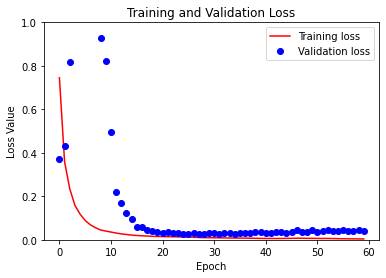

In [11]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [12]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 134ms/step - loss: 0.0579 - accuracy: 0.9825


[0.057878244668245316, 0.9824883341789246]

In [13]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

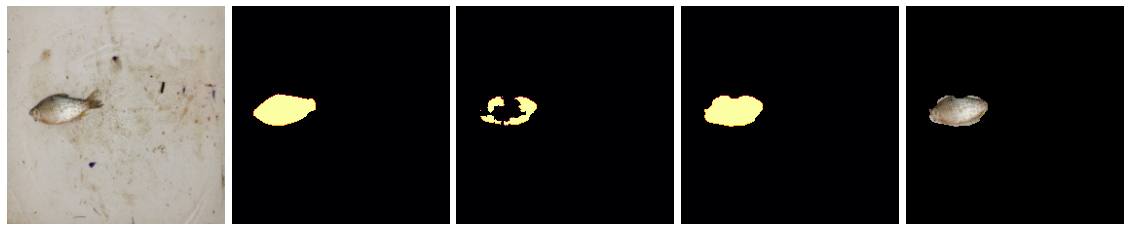

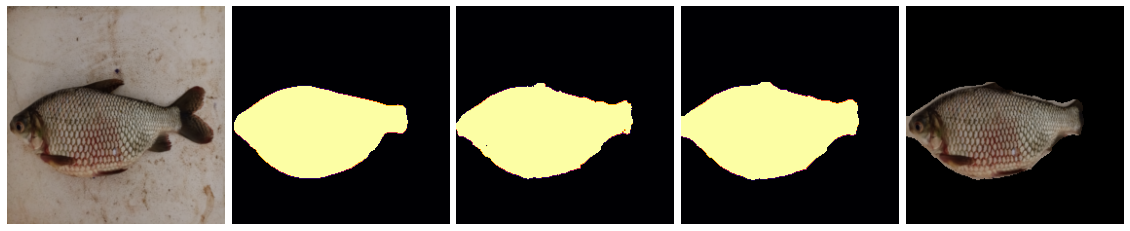

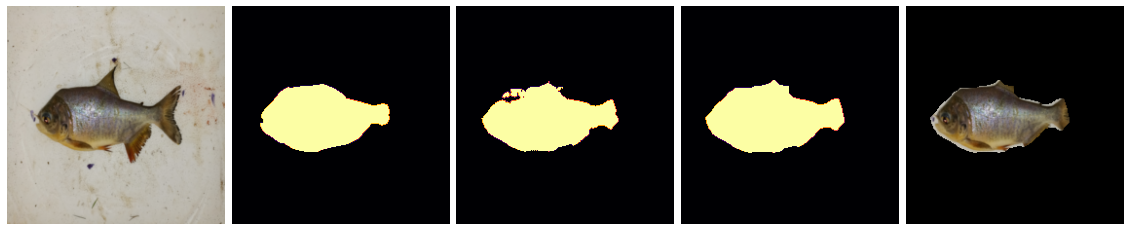

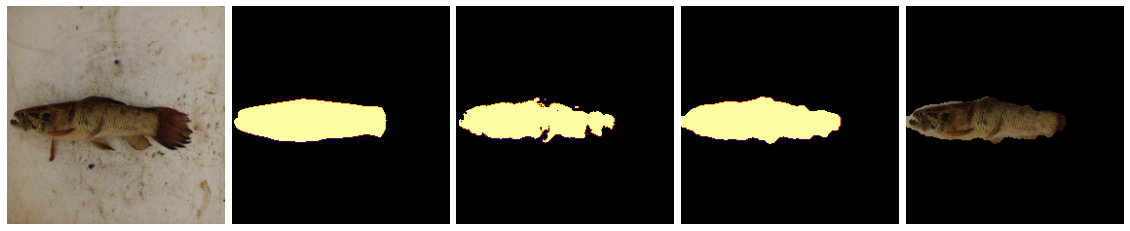

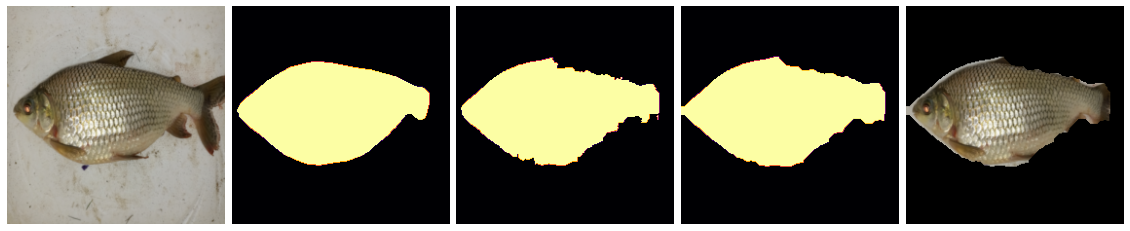

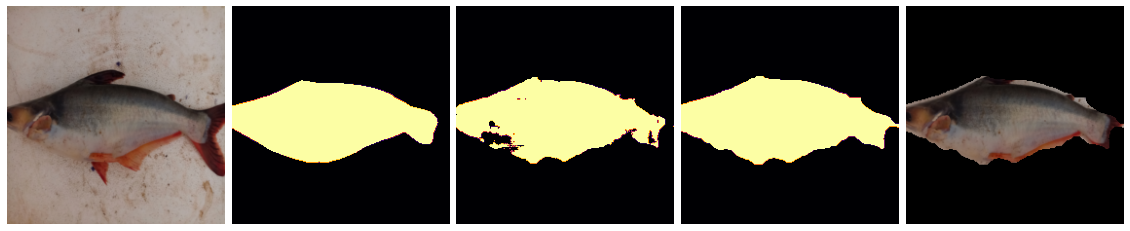

In [16]:
for index in range(len(y_pred)):
    
    predict_mask = create_mask(y_pred_thresholded[index])
    original_mask = y_test[index]
    
    mask_smoothed = smoothing_mask(predict_mask)
    
    image = X_test[index]
    
    merged = merge_image_mask(image, mask_smoothed)
    
    plot([image, 
          original_mask,
          predict_mask,
          mask_smoothed,
          merged], (1, 5))